In [1]:
%config InlineBackend.figure_format ='retina'

from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import pandas as pd
import numpy as np
import os

import sys

sys.path.insert(0, '../')

from global_config import config

results_dir   = config.get_property('results_dir')
data_dir      = config.get_property('data_dir')

#%% Plot Tong's default setting
SMALL_SIZE  = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font',   size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes',   titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels"
plt.rc('ytick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')


In [2]:
path_to_frcst_1 = os.path.join(results_dir, "forecast", "arima")
path_to_frcst_2 = os.path.join(results_dir, "forecast", "eakf_model1")
path_to_frcst_3 = os.path.join(results_dir, "forecast", "eakf_model2")
path_to_frcst_4 = os.path.join(results_dir, "forecast", "eakf_model3")

evals_df        = pd.read_csv(os.path.join(results_dir, "forecast", "evaluation", "scores.csv"), parse_dates=["frsct_date"])
usa_df          = pd.read_csv(os.path.join(data_dir, "processed_data_us.csv"))
usa_df["date"]  = pd.to_datetime(usa_df["date"])
dates_forecasts = usa_df.date[11:].values


In [3]:
def create_df_ensemble(weights_df, forecast_df_list, name_models):
    e_df = [forecast_df_list[idx]* weights_df.loc[name_models[idx]]["weigth"] for idx in range(len(forecast_df_list))]
    e_df = sum(e_df)
    return e_df

In [4]:
all_past_df   = pd.read_csv(os.path.join(results_dir, "forecast", "evaluation",  "BD_scores_all_past.csv"), parse_dates=["frsct_date"]); all_past_df["frsct_date"] = all_past_df["forecast_date"]
eq_weights_df = pd.read_csv( os.path.join(results_dir, "forecast", "evaluation", "BD_scores_equal_weights.csv"), parse_dates=["frsct_date"])
k_past_df     = pd.read_csv(os.path.join(results_dir, "forecast", "evaluation",  "BD_scores_K_past.csv"), parse_dates=["frsct_date"]); k_past_df["frsct_date"] = k_past_df["forecast_date"]
k_past        = ['2_past_ens', '3_past_ens', '4_past_ens', '5_past_ens', '6_past_ens']
k_past_df     = pd.concat([k_past_df, all_past_df])


In [5]:
%config InlineBackend.figure_format ='retina'
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns
import pylab

weekdict = {'1m': 1, '2m': 2, '3m': 3, '4m': 4, '5m': 5, '6m': 6}

def format_type_label_ensmelbe(s):
    if s == "all_past_ens":
        return "All past"
    else:
        return s[0]+" months"

NUM_COLORS = 6
cm         = pylab.get_cmap('gist_ncar')
paletteee  = [cm(idx_c/NUM_COLORS) for idx_c in range(NUM_COLORS)]


#%% Plot default setting
SMALL_SIZE  = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font',   size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes',   titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels"
plt.rc('ytick',  labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

In [ ]:
pi

ro

In [6]:
scores_models_df = pd.read_csv(os.path.join(results_dir, "forecast", "evaluation", "BD_scores.csv"), parse_dates=["frsct_date"])

model_stats_df = scores_models_df.copy()
ens_stats_df   = k_past_df.copy()

eq_weights_resume_df = eq_weights_df

ens_stats_df = ens_stats_df[ens_stats_df.method.isin(["2_past_ens", "3_past_ens", "4_past_ens", "5_past_ens", "6_past_ens", "all_past_ens"])]
lines_fit_df = ens_stats_df.copy() # pd.concat([ens_stats_df, eq_weights_resume_df])
lines_fit_df = lines_fit_df[lines_fit_df.eval_horizon_ensemble=="6m"].drop(columns=["mae", "error", "eval_horizon_ensemble", "score", "method", "frsct_date", "type"])

In [7]:
years          = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
pre_vac_years  = years[:6]
post_vac_years = years[6:]


In [11]:
past2num                      = {'2_past_ens': 2, '3_past_ens' : 3, '4_past_ens' : 4, '5_past_ens' : 5, '6_past_ens' : 6, 'all_past_ens' : 7}

lines_fit_df["x_reg"]         = lines_fit_df["type_ensemble"].map(past2num)
lines_fit_df["forecast_date"] = pd.to_datetime(lines_fit_df["forecast_date"])
lines_fit_df["year"]          = lines_fit_df["forecast_date"].dt.year

line_data_df = pd.DataFrame(columns=[ "type_ensemble", "x_reg", "wis", "eval_horizon", "data_split"])

name_split = ["All study period", "Pre-vaccine", "Post-vaccine"]

for evaluation_horizon in ["1m", "2m", "3m", "4m", "5m", "6m"]:

    for i, data_split in enumerate([years, pre_vac_years, post_vac_years]):
        line_df                 = lines_fit_df.query(f"eval_horizon == '{evaluation_horizon}'").query(f"year in {[int(y) for y in data_split]}")
        line_df                 = line_df.groupby(["type_ensemble", "x_reg"]).agg({"wis" : "mean"}).reset_index()
        line_df["eval_horizon"] = evaluation_horizon
        line_df["data_split"]   = name_split[i]

        line_data_df = pd.concat([line_data_df, line_df])


In [12]:
def linear_reg(x_naive, y):
    x_naive  = np.expand_dims(x_naive, axis=1)
    xreg     = np.concatenate([np.ones_like((x_naive)), x_naive], axis=1)

    teta = np.linalg.pinv(xreg.T @ xreg) @ xreg.T @ y
    yhat = np.dot(xreg, teta)

    return teta, yhat


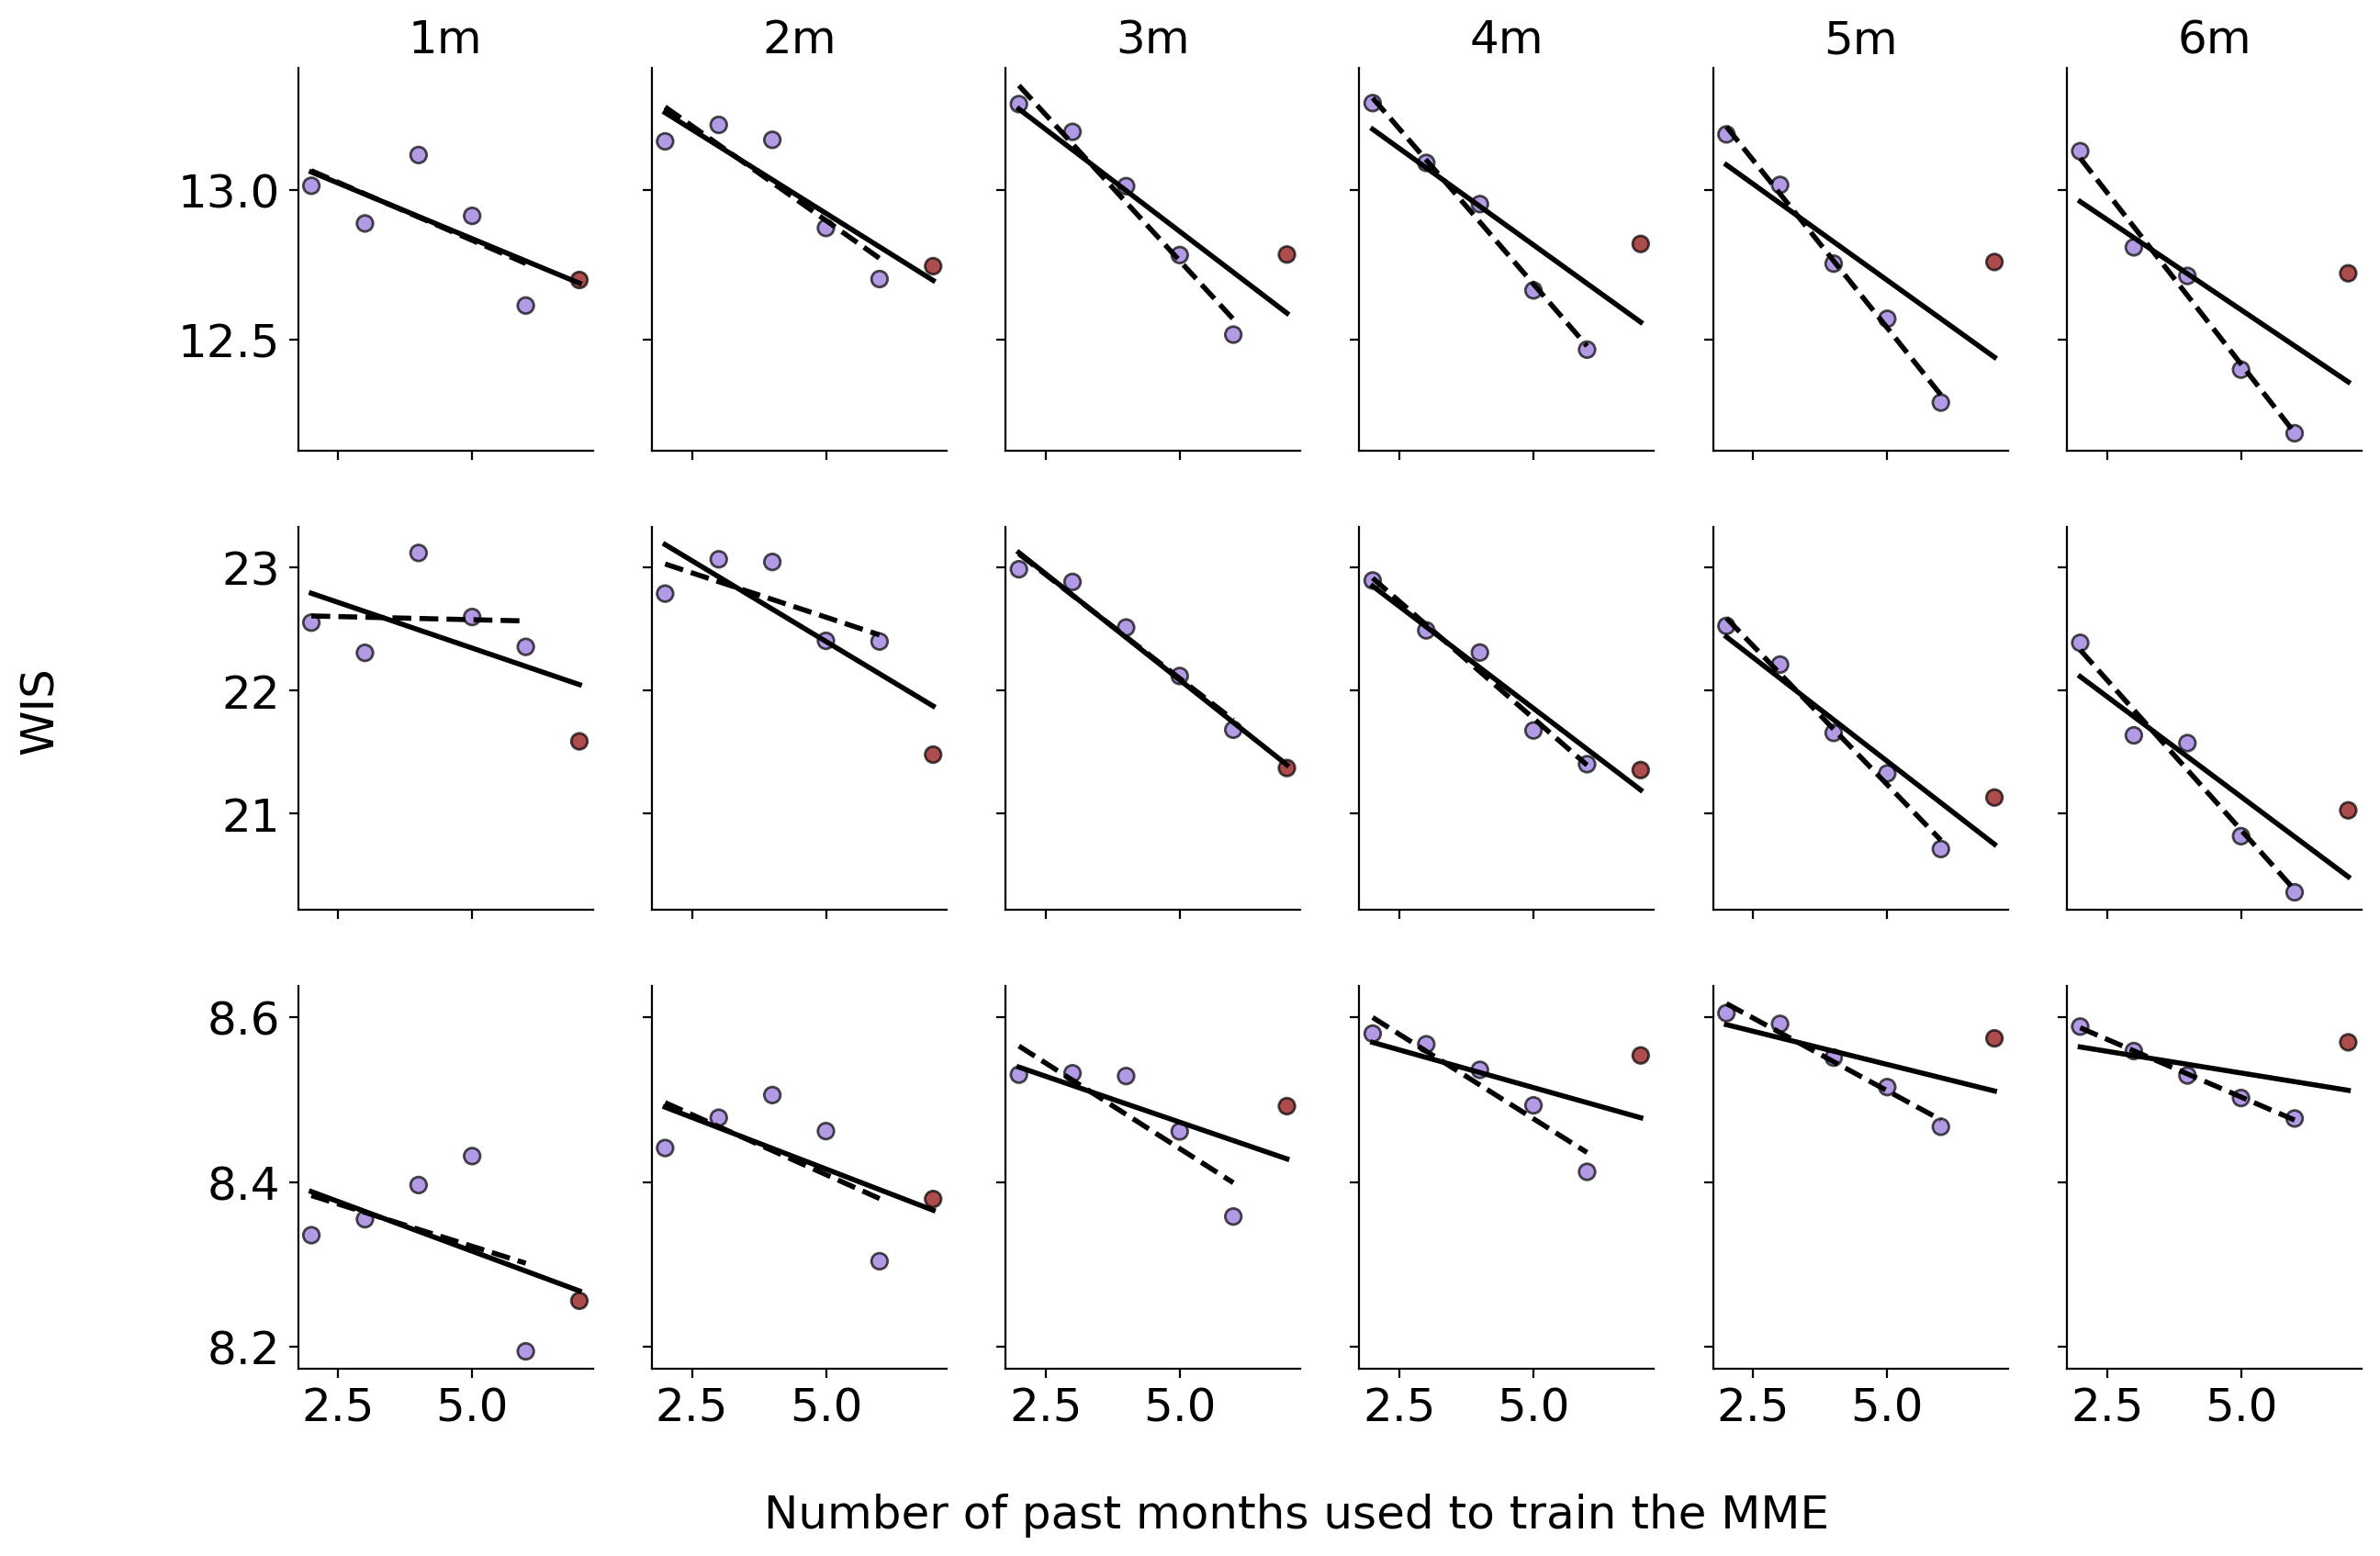

In [13]:
fig, ax = plt.subplots(3, 6, figsize=(14.5, 9.2), sharex=True, sharey="row")

for ix, data_split in enumerate(name_split):
    for iy, eh in enumerate(["1m", "2m", "3m", "4m", "5m", "6m"]):

        plt_df = line_data_df.query(f"data_split == '{data_split}' & eval_horizon == '{eh}'")

        p, yhat = linear_reg(np.double(plt_df.x_reg), plt_df.wis)
        ax[ix, iy].plot(plt_df.x_reg, yhat, color="k", lw=2)

        p, yhat = linear_reg(np.double(plt_df.x_reg)[:-1], plt_df.wis[:-1])
        ax[ix, iy].plot(plt_df.x_reg[:-1], yhat, color="k", lw=2, ls="--")

        ax[ix, iy].scatter(plt_df.x_reg, plt_df.wis, ec="k", fc=["mediumpurple", "mediumpurple", "mediumpurple", "mediumpurple", "mediumpurple", "darkred"], alpha=0.7, s=40)
        ax[ix, iy].spines['right'].set_visible(False)
        ax[ix, iy].spines['top'].set_visible(False)

for iy, eh in enumerate(["1m", "2m", "3m", "4m", "5m", "6m"]):
    ax[0, iy].set_title(f"{eh}")

fig.supxlabel("Number of past months used to train the MME")
fig.supylabel("WIS")


fig.savefig(os.path.join(results_dir, "figures", "reviews", "performance_fcast_horizon.png"), dpi=300, transparent=True)
